In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import seaborn as sns
from Class import DataAnalyzer
from scipy import stats
import calendar
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Define the file path
file_path = r'C:\Users\ljfit\Desktop\Random Coding\Fitbit Project\sql_tables\fourth_stage.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Convert 'ActivityDate' column to datetime type
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'], format='%d/%m/%Y')

# Feature Engineering: Total active minutes
df['TotalActiveMinutes'] = df['VeryActiveMinutes'] + df['FairlyActiveMinutes'] + df['LightlyActiveMinutes']
total_active_minutes = df['TotalActiveMinutes'].sum()

# Feature Engineering: Split ActivityDate into year, month, day, day of week, weekend columns
df['Day'] = df['ActivityDate'].dt.day

# Convert df['Day'] to number of days since the first day in the dataset
df['Day'] = df['ActivityDate'].dt.day
df['DayOfWeek'] = df['ActivityDate'].dt.dayofweek
df['Weekend'] = np.where(df['DayOfWeek'] > 4, 1, 0) # Create weekend column (0 = Mon-Fri, 1 = Sat-Sun)

# Create an instance of the DataAnalyzer class
data_analyzer = DataAnalyzer(df)

# Discern sedentary categories
def sedentary_segment(minutes):
    if minutes < 4*60:  # Less than 4 hours
        return "Low sedentary"
    elif 4*60 <= minutes <= 8*60:  # 4-8 hours
        return "Moderate sedentary"
    else:  # More than 8 hours
        return "High sedentary"


# Apply the function to the sedentaryminutes column
df['Sedentary_Segment'] = df['SedentaryMinutes'].apply(sedentary_segment)
average_caloric_burn_per_segment = df.groupby('Sedentary_Segment')['Calories'].mean().rename('Average Caloric Burn').reset_index()
print(average_caloric_burn_per_segment)

# Group average steps, calories, and sleep by ID
daily_avg_ID = df.groupby('Id').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean',
    'TotalMinutesAsleep': 'mean',
    'TotalActiveMinutes': 'mean'
}).reset_index()

# Rename columns for clarity
daily_avg_ID.columns = ['id', 'mean_daily_steps', 'mean_daily_calories', 'mean_daily_sleep', 'mean_daily_active_minutes']

# Customer Segmentation Analysis
def classify_by_steps(average_steps):
    if average_steps < 5000:
        return "Sedentary"
    elif 5000 <= average_steps < 7500:
        return "Lightly active"
    elif 7500 <= average_steps < 10000:
        return "Fairly active"
    else:
        return "Very active"

# Apply the function to the 'mean_daily_steps' column to create a new 'Activity_Category' column
daily_avg_ID['Activity_Category'] = daily_avg_ID['mean_daily_steps'].apply(classify_by_steps)
# Apply the function to the 'mean_daily_steps' column to create a new 'Sedentary_Category' column
daily_avg_ID['Sedentary_Category'] = daily_avg_ID['mean_daily_sleep'].apply(sedentary_segment)
# print(daily_avg_ID)

    Sedentary_Segment  Average Caloric Burn
0      High sedentary           1987.580189
1       Low sedentary           1763.000000
2  Moderate sedentary           1735.333333


In [41]:
# Convert the DatetimeIndex to day names
df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Group by 'DayOfWeek' and calculate the mean by Id
steps_by_day = df.groupby('DayOfWeek')['TotalSteps'].mean()

print(steps_by_day)

# Initialize empty DataFrame to hold aggregated results
agg_df = pd.DataFrame()

# Group by 'Id'
grouped = df.groupby('Id')

# Create aggregate DataFrame
# Loop through the groups
for name, group in grouped:
    print(f"Id: {name}")

    # Calculate the mean steps, sleep, and calories for this group by 'DayOfWeek'
    mean_values = group.groupby('ActivityDate').agg({
        'TotalSteps': 'mean',
        'TotalMinutesAsleep': 'mean',
        'Calories': 'mean',
        'TotalActiveMinutes': 'mean'
    }).reset_index()

    # Add 'Id' column to the mean_values DataFrame
    mean_values['Id'] = name

    # Append this to the aggregate DataFrame
    agg_df = pd.concat([agg_df, mean_values], ignore_index=True)

# Convert the DatetimeIndex to day names
Day = df['DayOfWeek']
agg_df = pd.concat([agg_df, Day], axis = 1)
# print(agg_df)

# Apply the function to the 'mean_daily_steps' column to create a new 'Activity_Category' column
agg_df['Activity_Category'] = agg_df['TotalSteps'].apply(classify_by_steps)
# Apply the function to the 'mean_daily_steps' column to create a new 'Sedentary_Category' column
agg_df['Sedentary_Category'] = agg_df['TotalMinutesAsleep'].apply(sedentary_segment)

# Group by 'Activity_Category' and count each group
user_type_percent = daily_avg_ID.groupby('Activity_Category').size().reset_index(name='total')
# Calculate the total number of users
user_type_percent['totals'] = user_type_percent['total'].sum()
# Calculate the percentage for each user type
user_type_percent['Total_Percent'] = user_type_percent['total'] / user_type_percent['totals']
# Convert the percentage to a readable format
user_type_percent['percentage%'] = user_type_percent['Total_Percent'].apply(lambda x: f"{x*100:.2f}%")
# Reorder the levels of the user type
ordered_categories = ["Very active", "Fairly active", "Lightly active", "Sedentary"]
user_type_percent['Activity_Category'] = pd.Categorical(user_type_percent['Activity_Category'], categories=ordered_categories, ordered=True)
user_type_percent = user_type_percent.sort_values('Activity_Category')

# Testing statistical difference in caloric burn between the different user types based on the one-way ANOVA test.
# Create a list of the different user types and Group data by Activity_Category.
groups = [agg_df['Calories'][agg_df['Activity_Category'] == category] for category in ordered_categories]

# Average Data by Day by Id
daily_avg_ID['efficiency_per_step'] = daily_avg_ID['mean_daily_calories'] / daily_avg_ID['mean_daily_steps']
daily_avg_ID['efficiency_per_minute'] = daily_avg_ID['mean_daily_calories'] / daily_avg_ID['mean_daily_active_minutes']

# Average Data by Day by Id by day of week
agg_df['efficiency_per_step'] = agg_df['Calories'] / agg_df['TotalSteps']
agg_df['efficiency_per_minute'] = agg_df['Calories'] / agg_df['TotalActiveMinutes']

# print(daily_avg_ID)
print(agg_df)


DayOfWeek
Friday       5779.142857
Monday       6687.214286
Saturday     7506.714286
Sunday       6600.607143
Thursday     6285.000000
Tuesday      6767.171429
Wednesday    6028.857143
Name: TotalSteps, dtype: float64
Id: 1503960366
Id: 1624580081
Id: 1644430081
Id: 1844505072
Id: 1927972279
Id: 2022484408
Id: 2026352035
    ActivityDate  TotalSteps  TotalMinutesAsleep  Calories  \
0     2016-04-12     13162.0               327.0    1985.0   
1     2016-04-13     10735.0               384.0    1797.0   
2     2016-04-14     10460.0                 0.0    1776.0   
3     2016-04-15      9762.0               412.0    1745.0   
4     2016-04-16     12669.0               340.0    1863.0   
..           ...         ...                 ...       ...   
211   2016-05-08      5528.0               541.0    1555.0   
212   2016-05-09     10685.0               531.0    1869.0   
213   2016-05-10       254.0               357.0    1141.0   
214   2016-05-11      8580.0               523.0    1698.

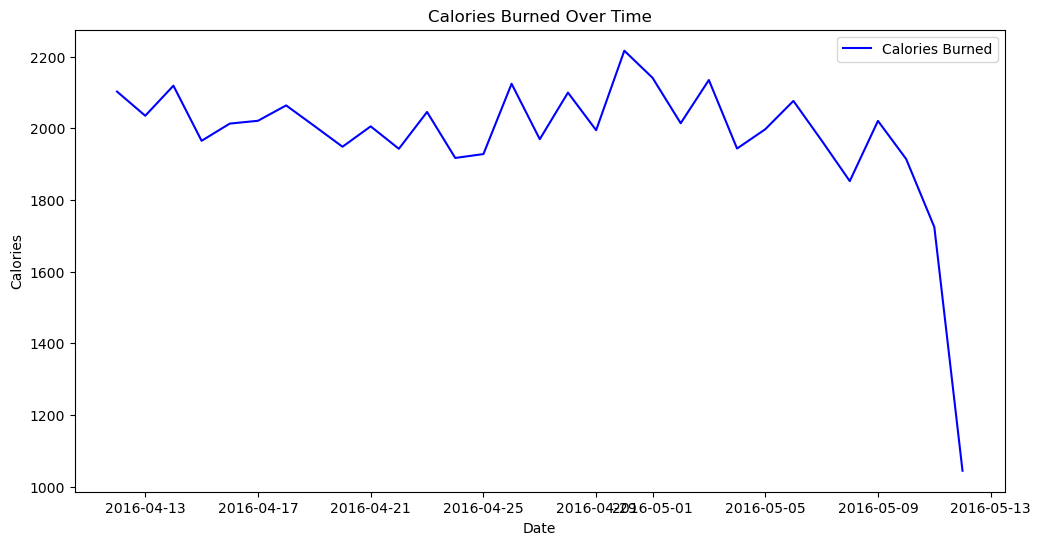

Best Hyperparameters:
Order: (1, 1, 1)
Seasonal Order: (1, 1, 1, 7)
R-squared with Best Estimator: -3.524703433922987
Mean Absolute Error with Best Estimator: 124.71428571428578
Root Mean Squared Error with Best Estimator: 141.3025412484338


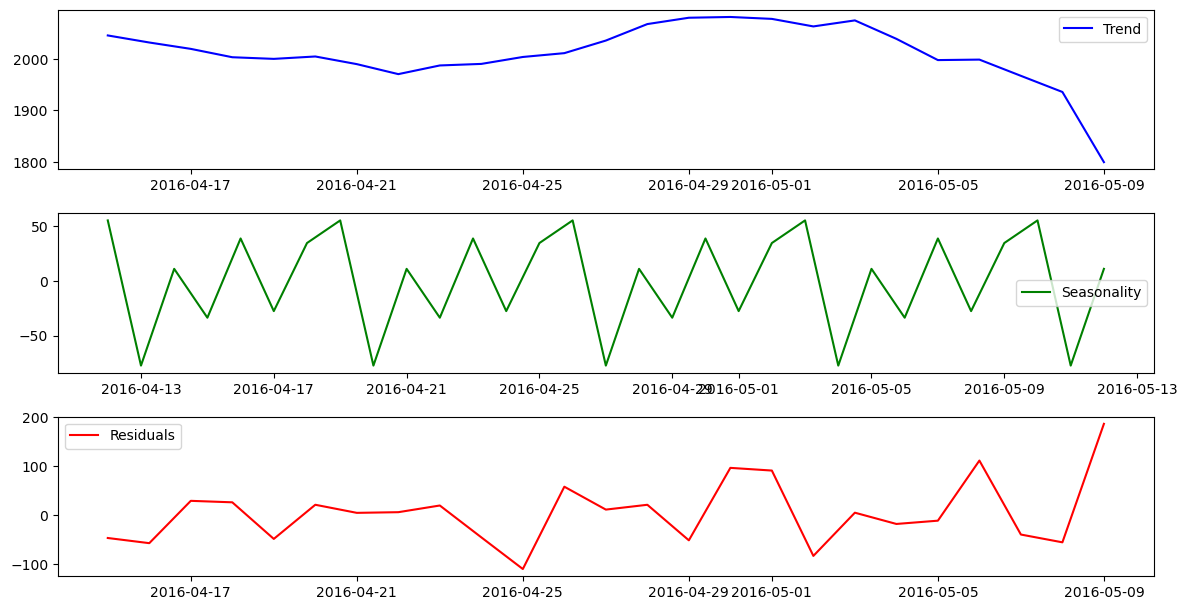

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

## TIME SERIES ANALYSIS
# Set 'ActivityDate' as the index of the DataFrame
agg_df.set_index('ActivityDate', inplace=True)

# Resample data to a daily frequency
daily_df = agg_df.resample('D').mean()

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_df.index, daily_df['Calories'], label='Calories Burned', color='blue')
plt.title('Calories Burned Over Time')
plt.xlabel('Date')
plt.ylabel('Calories')
plt.legend()
plt.show()

# Time Series Decomposition (Trend, Seasonality, Residual)
decomposition = sm.tsa.seasonal_decompose(daily_df['Calories'], model='additive')

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend()
plt.tight_layout()

# Create lag features for time series analysis (same as before)
num_lags = 7
for i in range(1, num_lags + 1):
    daily_df[f'Lag_{i}_Calories'] = daily_df['Calories'].shift(i)
daily_df.dropna(inplace=True)

# Split the data into training and test sets
train_size = int(0.8 * len(daily_df))
train_data, test_data = daily_df[:train_size], daily_df[train_size:]

# Define a SARIMA model function
def sarima_estimator(order, seasonal_order):
    model = SARIMAX(train_data['Calories'], order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)

# Define a function to evaluate SARIMA models
def evaluate_sarima(order, seasonal_order):
    model = sarima_estimator(order, seasonal_order)
    y_pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    rmse = np.sqrt(mean_squared_error(test_data['Calories'], y_pred))
    return rmse

# Define the SARIMA hyperparameter grid
order_grid = [(1, 1, 1), (1, 1, 2)]
seasonal_order_grid = [(1, 1, 1, 7)]  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# Loop through hyperparameter combinations and find the best model
for order in order_grid:
    for seasonal_order in seasonal_order_grid:
        rmse = evaluate_sarima(order, seasonal_order)
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            best_seasonal_order = seasonal_order

print("Best Hyperparameters:")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal_order)

# Train the best SARIMA model on the entire training data
best_model = sarima_estimator(best_order, best_seasonal_order)

# Forecast on the test data
y_pred = best_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Calculate R-squared
r_squared = r2_score(test_data['Calories'], y_pred)
print("R-squared with Best Estimator:", r_squared)

# Calculate MAE
mae = mean_absolute_error(test_data['Calories'], y_pred)
print("Mean Absolute Error with Best Estimator:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['Calories'], y_pred))
print("Root Mean Squared Error with Best Estimator:", rmse)

# You can't set hyperparameters for GridSearchCV with SARIMA as 
# statsmodels doesn't have a set_params method like some other scikit-learn estimators.
# Model Interpretability is not applicable for SARIMA
# This code manually loops through the hyperparameter combinations and selects the best SARIMA model based on RMSE. 
# It then evaluates the model on the test data and calculates performance metrics. 
# Note that SARIMA models don't have feature importances, so that section is not applicable.


ValueError: could not broadcast input array from shape (7,) into shape (41,)

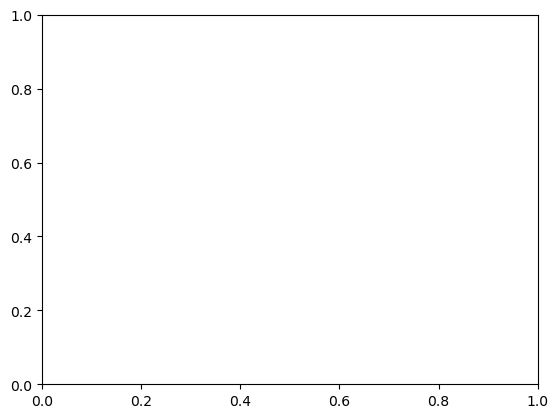

In [43]:
# Some more examples of code which can be added to this project.

# Load your time series data here

# ... Existing code for resampling, lag features, splitting data, and SARIMA model ...

# Additional Feature Engineering: Rolling Statistics
window_size = 7  # Choose an appropriate window size
daily_df['Rolling_Mean'] = daily_df['Calories'].rolling(window=window_size).mean()
daily_df['Rolling_Std'] = daily_df['Calories'].rolling(window=window_size).std()

# Exploratory Data Analysis (EDA)
# Visualize autocorrelation plot
sm.graphics.tsa.plot_acf(daily_df['Calories'], lags=40)
plt.show()

# Model Selection: Try an Exponential Smoothing model (Holt-Winters)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
exp_smooth = ExponentialSmoothing(train_data['Calories'], trend='add', seasonal='add', seasonal_periods=7)
exp_smooth_fit = exp_smooth.fit()
exp_smooth_pred = exp_smooth_fit.forecast(len(test_data))

# Hyperparameter Tuning: For Exponential Smoothing, there are alpha, beta, and gamma parameters that can be tuned

# Ensemble Models: Combine SARIMA and Exponential Smoothing forecasts
ensemble_forecast = (y_pred + exp_smooth_pred) / 2

# Cross-Validation: Use Walk-Forward Validation for time series data

# Model Evaluation: Calculate additional metrics like MAPE and SMAPE

# Forecast Visualization: Plot the forecasted values with confidence intervals

# Model Monitoring and Maintenance: Implement a retraining schedule

# Error Analysis: Analyze model errors to identify patterns and improve the models

# Advanced Techniques: Explore Bayesian structural time series (BSTS) or deep learning models

# Alerting and Reporting: Implement alerts or reporting mechanisms